In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from phantoms.utils.CKA.CKA import linear_CKA, kernel_CKA
import umap.umap_ as umap


In [2]:
def load_embeddings(experiment_dir, layer_names):
    """
    Load embeddings for specified layers from a given experiment directory.

    Args:
        experiment_dir (str): Path to the experiment's embedding directory.
        layer_names (list): List of layer names to load embeddings for.

    Returns:
        dict: Mapping from layer name to its embedding matrix.
    """
    embeddings = {}
    for layer in layer_names:
        layer_path = os.path.join(experiment_dir, f"{layer}.npy")
        if os.path.exists(layer_path):
            embeddings[layer] = np.load(layer_path)
        else:
            print(f"Warning: {layer_path} not found.")
    return embeddings


def compute_layer_cka(embeddings_model1, embeddings_model2, layer_name1, layer_name2):
    """
    Compute CKA scores between two models for a specific layer.

    Args:
        embeddings_model1 (dict): Embeddings from model 1.
        embeddings_model2 (dict): Embeddings from model 2.
        layer_name1 (str): The layer to compare.
        layer_name2 (str): The layer to compare.

    Returns:
        tuple: (linear_cka_score, rbf_cka_score)
    """
    X = embeddings_model1.get(layer_name1)
    Y = embeddings_model2.get(layer_name2)
    
    if X is None or Y is None:
        print(f"Embeddings for layer '{layer_name1}' or '{layer_name2}' are missing in one of the models.")
        return None, None
    
    # Transpose to shape (embedding_dim, num_samples)
    X = X.T
    Y = Y.T
    
    # Compute CKA scores
    linear_cka_score = linear_CKA(X, Y)
    rbf_cka_score = kernel_CKA(X, Y)
    
    return linear_cka_score, rbf_cka_score


def plot_cka_scores(cka_scores, layer_names, model_names, title="CKA Heatmap"):
    """
    Plot a heatmap of CKA scores.

    Args:
        cka_scores (np.ndarray): 2D array of CKA scores.
        layer_names (list): List of layer names.
        model_names (list): List of model names.
        title (str): Title of the heatmap.
    """
    plt.figure(figsize=(12, 8))
    sns.heatmap(cka_scores, annot=True, fmt=".2f",
                xticklabels=model_names, yticklabels=layer_names,
                cmap='viridis')
    plt.xlabel('Model 2 Layers')
    plt.ylabel('Model 1 Layers')
    plt.title(title)
    plt.tight_layout()
    plt.show()

def project_embeddings_umap(embeddings_dict, n_neighbors=15, min_dist=0.1, metric='euclidean', random_state=42, figsize=(12, 10), save_path=None):
    """
    Projects embeddings into 2D space using UMAP and plots them colored by layer.

    Args:
        embeddings_dict (dict): A dictionary where keys are layer names and values are np arrays of shape [num_samples, embedding_dim].
        n_neighbors (int): UMAP parameter. Controls local versus global structure in the data.
        min_dist (float): UMAP parameter. Controls how tightly UMAP packs points together.
        metric (str): UMAP parameter. The metric to use for distance computation.
        random_state (int): Random state for reproducibility.
        figsize (tuple): Size of the matplotlib figure.
        save_path (str, optional): If provided, saves the plot to the specified path.

    Returns:
        None
    """
    # Validate input
    if not isinstance(embeddings_dict, dict):
        raise ValueError("embeddings_dict must be a dictionary with layer names as keys and embedding arrays as values.")

    # Collect embeddings and labels
    all_embeddings = []
    labels = []
    for layer, emb in embeddings_dict.items():
        if not isinstance(emb, np.ndarray):
            raise ValueError(f"Embeddings for layer '{layer}' must be a NumPy array.")
        all_embeddings.append(emb)
        labels.extend([layer] * emb.shape[0])

    # Concatenate all embeddings
    concatenated_embeddings = np.concatenate(all_embeddings, axis=0)
    print(f"Total embeddings shape after concatenation: {concatenated_embeddings.shape}")

    # Create a DataFrame for UMAP
    df_embeddings = pd.DataFrame(concatenated_embeddings)
    df_embeddings['Layer'] = labels

    # Initialize UMAP
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, metric=metric, random_state=random_state)

    # Fit and transform the embeddings
    embedding_2d = reducer.fit_transform(df_embeddings.drop('Layer', axis=1))
    df_embeddings['UMAP1'] = embedding_2d[:, 0]
    df_embeddings['UMAP2'] = embedding_2d[:, 1]

    # Debugging: Check the shape of the reduced embeddings
    print(f"UMAP embedding shape: {embedding_2d.shape}")

    # Plotting
    plt.figure(figsize=figsize)
    sns.scatterplot(
        data=df_embeddings,
        x='UMAP1',
        y='UMAP2',
        hue='Layer',
        palette='tab10',
        s=50,
        alpha=0.7
    )
    plt.title('UMAP Projection of Layer Embeddings', fontsize=16)
    plt.xlabel('UMAP1', fontsize=14)
    plt.ylabel('UMAP2', fontsize=14)
    plt.legend(title='Layer', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    # Save the plot if a save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"UMAP plot saved to {save_path}")

    plt.show()

In [5]:
os.listdir('/Users/macbook/CODE/PhantoMS/experiments_run/2025-02-04_12-13-32_denovo_test/embeddings')


['gnn_1_head_1.npy',
 'decoder_layer_3_head_1.npy',
 'decoder_layer_3_head_3.npy',
 'gnn_1_head_2.npy',
 'gnn_1_head_3.npy',
 'decoder_layer_3_head_2.npy',
 'gnn_3.npy',
 'gnn_2.npy',
 'gnn_1_head_4.npy',
 'gnn_1.npy',
 'decoder_layer_3_head_4.npy',
 'decoder_layer_4_head_4.npy',
 'decoder_layer_1_head_1.npy',
 'gnn_3_head_1.npy',
 'gnn_3_head_3.npy',
 'decoder_layer_1_head_2.npy',
 'decoder_layer_1_head_3.npy',
 'gnn_3_head_2.npy',
 'decoder_layer_4_head_2.npy',
 'decoder_layer_4_head_3.npy',
 'decoder_layer_4_head_1.npy',
 'decoder_layer_1_head_4.npy',
 'gnn_3_head_4.npy',
 'decoder_layer_2.npy',
 'decoder_layer_3.npy',
 'decoder_layer_1.npy',
 'decoder_layer_2_head_4.npy',
 'decoder_layer_4.npy',
 'decoder_layer_2_head_1.npy',
 'decoder_layer_2_head_3.npy',
 'decoder_layer_2_head_2.npy',
 'encoder_projection.npy',
 'gnn_2_head_4.npy',
 'gnn_2_head_1.npy',
 'gnn_2_head_3.npy',
 'gnn_2_head_2.npy']

In [6]:
experiment_dir1 = '/Users/macbook/CODE/PhantoMS/experiments_run/2025-02-04_12-13-32_denovo_test/embeddings'
experiment_dir2 = '/Users/macbook/CODE/PhantoMS/experiments_run/2025-02-04_12-18-47_denovo_bonus_test/embeddings'

# Specify the layers you want to compare
layer_names_by_heads = [
 'gnn_1_head_1',
 'gnn_1_head_2',
 'gnn_1_head_3',
 'gnn_1_head_4',
 'gnn_2_head_1',
 'gnn_2_head_2',
 'gnn_2_head_3',
 'gnn_2_head_4',
 'gnn_3_head_1',
 'gnn_3_head_2',
 'gnn_3_head_3',
 'gnn_3_head_4',
 'decoder_layer_1_head_1',
 'decoder_layer_1_head_2',
 'decoder_layer_1_head_3',
 'decoder_layer_1_head_4',
 'decoder_layer_2_head_1',
 'decoder_layer_2_head_2',
 'decoder_layer_2_head_3',
 'decoder_layer_2_head_4',
 'decoder_layer_3_head_1',
 'decoder_layer_3_head_2',
 'decoder_layer_3_head_3',
 'decoder_layer_3_head_4',
 'decoder_layer_4_head_1',
 'decoder_layer_4_head_2',
 'decoder_layer_4_head_3',
 'decoder_layer_4_head_4',]

In [7]:
embeddings_model1 = load_embeddings(experiment_dir1, layer_names_by_heads)
embeddings_model2 = load_embeddings(experiment_dir2, layer_names_by_heads)

In [8]:
# Compute and display CKA scores for each layer
for layer in layer_names_by_heads:
    linear_cka, rbf_cka = compute_layer_cka(embeddings_model1, embeddings_model2, layer, layer)
    if linear_cka is not None and rbf_cka is not None:
        print(f"Layer: {layer}")
        print(f"  Linear CKA: {linear_cka:.4f}")
        print(f"  RBF Kernel CKA: {rbf_cka:.4f}\n")

Layer: gnn_1_head_1
  Linear CKA: 0.7676
  RBF Kernel CKA: 0.7775

Layer: gnn_1_head_2
  Linear CKA: 0.7621
  RBF Kernel CKA: 0.7775

Layer: gnn_1_head_3
  Linear CKA: 0.7570
  RBF Kernel CKA: 0.7727

Layer: gnn_1_head_4
  Linear CKA: 0.7567
  RBF Kernel CKA: 0.7730

Layer: gnn_2_head_1
  Linear CKA: 0.3012
  RBF Kernel CKA: 0.3593

Layer: gnn_2_head_2
  Linear CKA: 0.2925
  RBF Kernel CKA: 0.3413

Layer: gnn_2_head_3
  Linear CKA: 0.3659
  RBF Kernel CKA: 0.4250

Layer: gnn_2_head_4
  Linear CKA: 0.3601
  RBF Kernel CKA: 0.4082

Layer: gnn_3_head_1
  Linear CKA: 0.0735
  RBF Kernel CKA: 0.1269

Layer: gnn_3_head_2
  Linear CKA: 0.1142
  RBF Kernel CKA: 0.1640

Layer: gnn_3_head_3
  Linear CKA: 0.0848
  RBF Kernel CKA: 0.1292

Layer: gnn_3_head_4
  Linear CKA: 0.1175
  RBF Kernel CKA: 0.1780

Layer: decoder_layer_1_head_1
  Linear CKA: 0.0009
  RBF Kernel CKA: 0.0046

Layer: decoder_layer_1_head_2
  Linear CKA: 0.0054
  RBF Kernel CKA: 0.0068

Layer: decoder_layer_1_head_3
  Linear CKA

In [9]:
# Initialize a matrix to store CKA scores
# Rows: Model1 layers, Columns: Model2 layers
cka_matrix = np.zeros((len(layer_names_by_heads), len(layer_names_by_heads), 2))  # Last dim for linear and RBF

for i, layer1 in enumerate(layer_names_by_heads):
    for j, layer2 in enumerate(layer_names_by_heads):
        linear_cka, rbf_cka = compute_layer_cka(embeddings_model1, embeddings_model2, layer1, layer2)
        if linear_cka is not None and rbf_cka is not None:
            cka_matrix[i, j, 0] = linear_cka
            cka_matrix[i, j, 1] = rbf_cka

In [10]:
for layer, layer_embeddings in embeddings_model2.items():
    print(layer, layer_embeddings.shape)

gnn_1_head_1 (17, 256)
gnn_1_head_2 (17, 256)
gnn_1_head_3 (17, 256)
gnn_1_head_4 (17, 256)
gnn_2_head_1 (17, 256)
gnn_2_head_2 (17, 256)
gnn_2_head_3 (17, 256)
gnn_2_head_4 (17, 256)
gnn_3_head_1 (17, 256)
gnn_3_head_2 (17, 256)
gnn_3_head_3 (17, 256)
gnn_3_head_4 (17, 256)
decoder_layer_1_head_1 (17, 256)
decoder_layer_1_head_2 (17, 256)
decoder_layer_1_head_3 (17, 256)
decoder_layer_1_head_4 (17, 256)
decoder_layer_2_head_1 (17, 256)
decoder_layer_2_head_2 (17, 256)
decoder_layer_2_head_3 (17, 256)
decoder_layer_2_head_4 (17, 256)
decoder_layer_3_head_1 (17, 256)
decoder_layer_3_head_2 (17, 256)
decoder_layer_3_head_3 (17, 256)
decoder_layer_3_head_4 (17, 256)
decoder_layer_4_head_1 (17, 256)
decoder_layer_4_head_2 (17, 256)
decoder_layer_4_head_3 (17, 256)
decoder_layer_4_head_4 (17, 256)


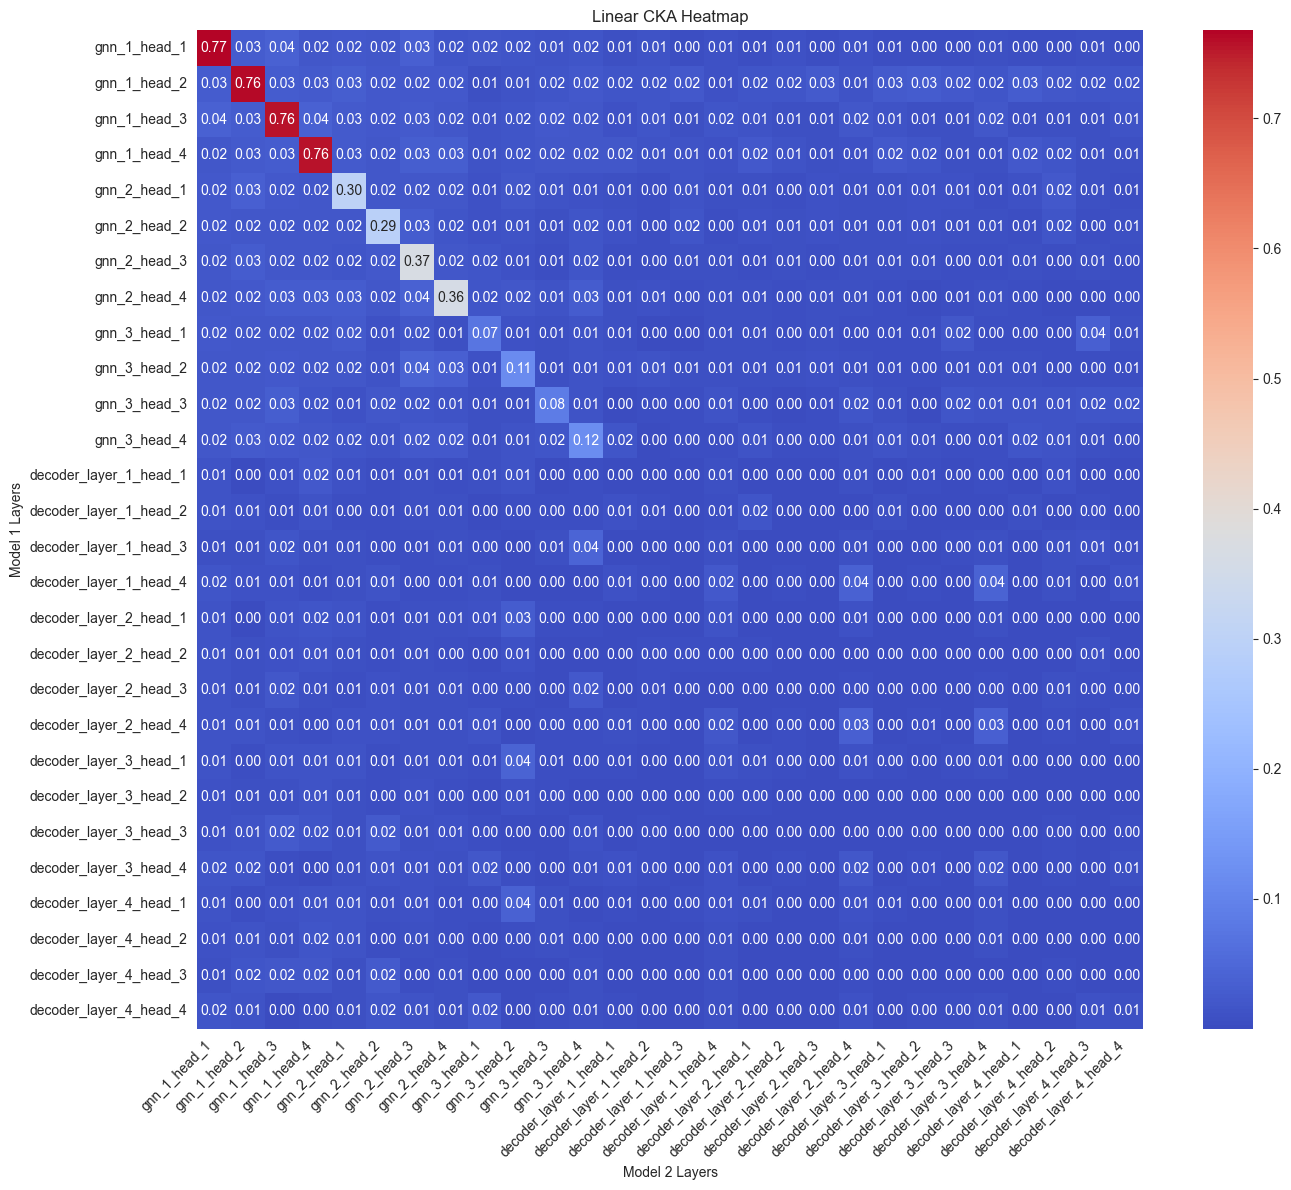

In [11]:
# Plot Linear CKA Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cka_matrix[:,:, 0], annot=True, fmt=".2f",
            xticklabels=layer_names_by_heads, yticklabels=layer_names_by_heads,
            cmap='coolwarm')
plt.xlabel('Model 2 Layers')
plt.ylabel('Model 1 Layers')
plt.title('Linear CKA Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

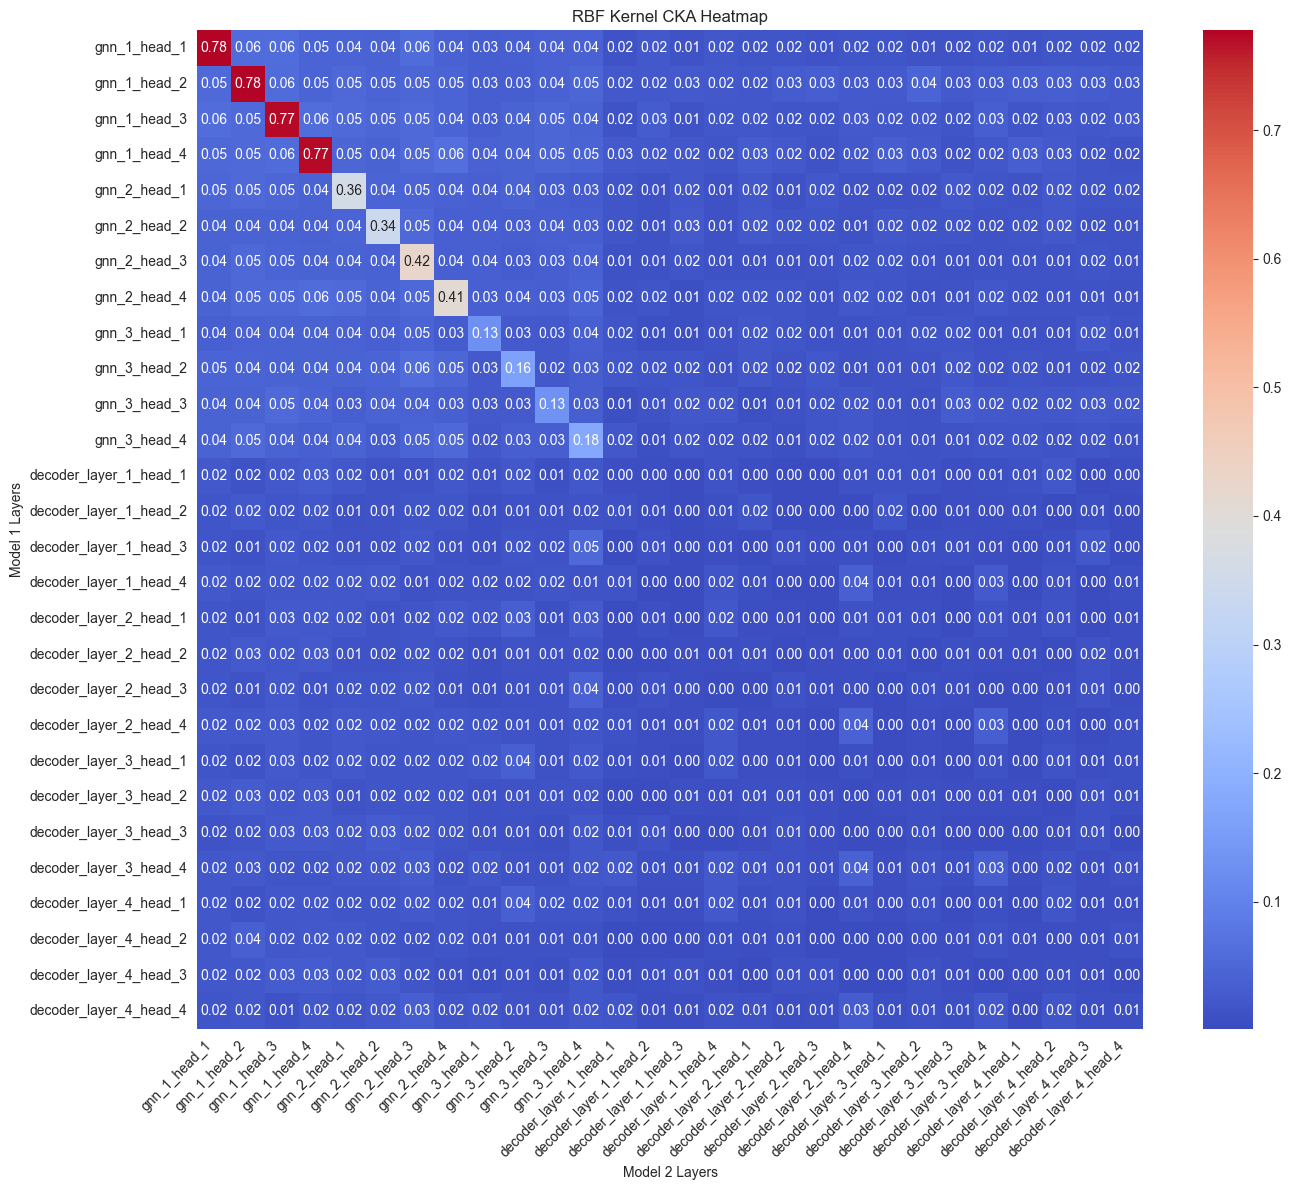

In [12]:
# Plot RBF Kernel CKA Heatmap
plt.figure(figsize=(14, 12))
sns.heatmap(cka_matrix[:, :, 1], annot=True, fmt=".2f",
            xticklabels=layer_names_by_heads, yticklabels=layer_names_by_heads,
            cmap='coolwarm')
plt.xlabel('Model 2 Layers')
plt.ylabel('Model 1 Layers')
plt.title('RBF Kernel CKA Heatmap')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Total embeddings shape after concatenation: (476, 256)


/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/macbook/UTILS/anaconda3/envs/phantoms_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP embedding shape: (476, 2)


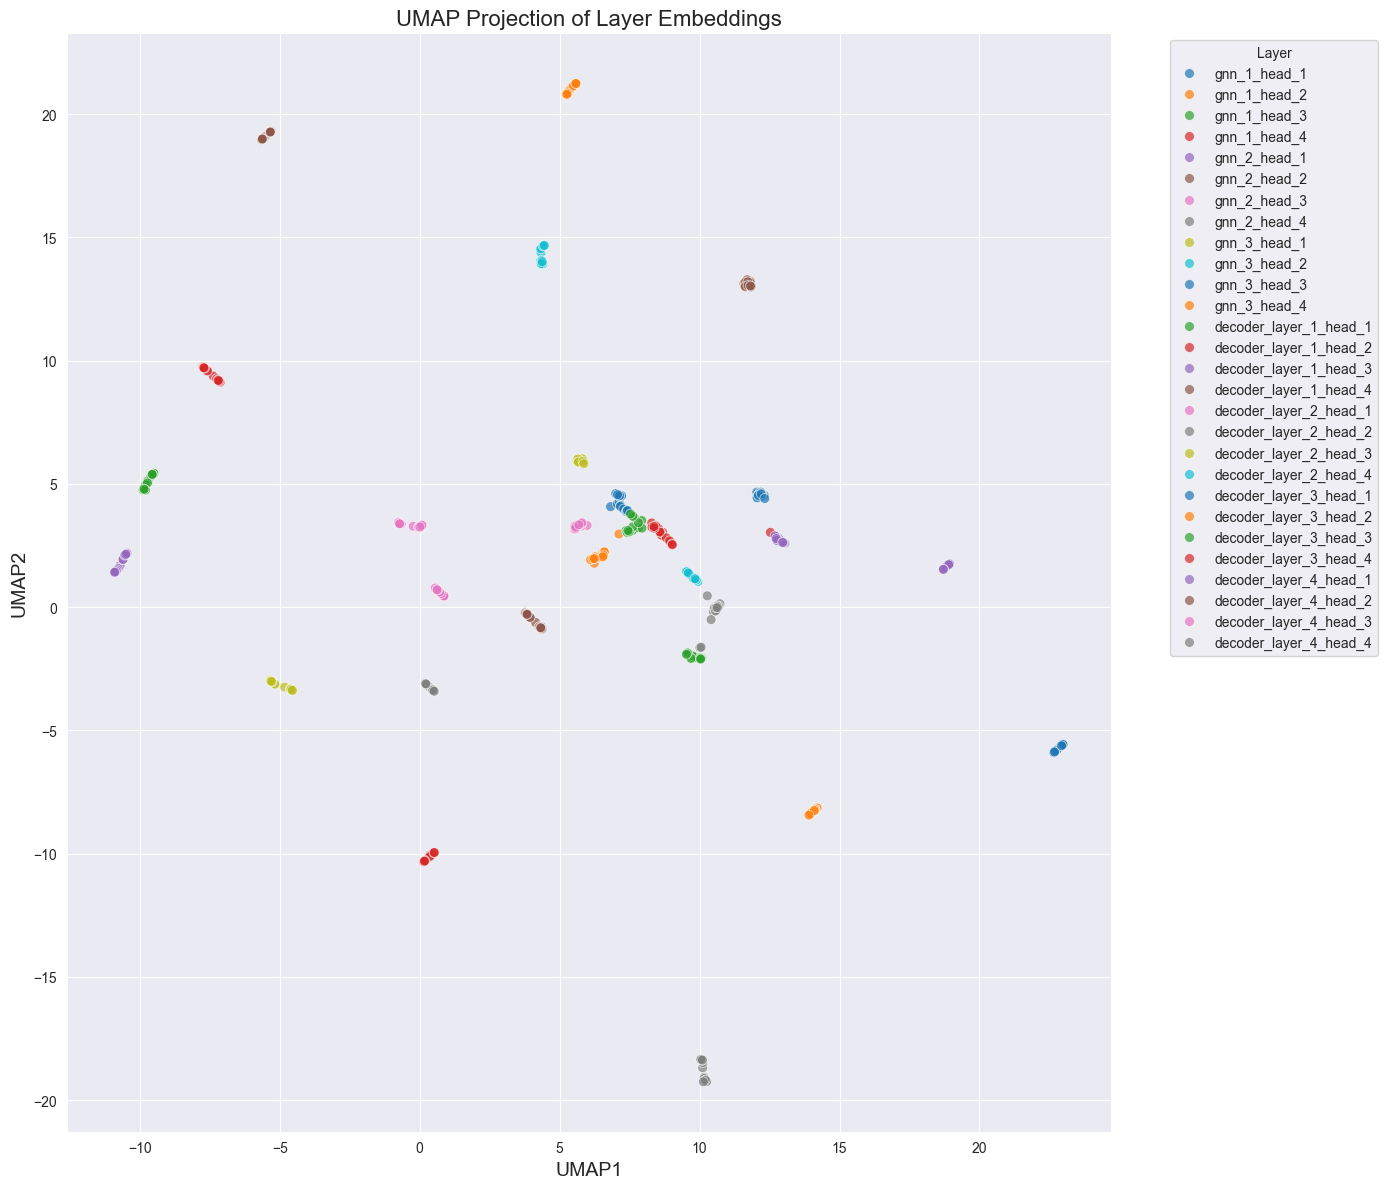

In [13]:
project_embeddings_umap(
    embeddings_dict=embeddings_model1,
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42,
    figsize=(14, 12),
    save_path=None
)